### Amazon dataset analysis 

In [1]:
import pandas as pd
df = pd.read_csv('/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/train.csv')
df1 = pd.read_csv('/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv')
df2= pd.read_csv('/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/val.csv')

print(len(df), len(df1), len(df2))

3240000 400000 360000


In [1]:
import torch
import pandas as pd
from comparative.models.classical.early_fusion import EarlyFusionClassifier
from comparative.datasets.amazon_datamodule import AmazonDataModule

# Adjust these paths to your model and data
checkpoint_path = "/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_early/last.ckpt"
data_dir = "/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/"

# Rebuild the datamodule (update with correct params as needed)
dm = AmazonDataModule(
    data_dir=data_dir,
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,  # for fast evaluation
    max_len=128,
    num_workers=8
)
dm.setup("test")  # ensure test_ds is loaded

# Load model (same params as you trained with)
model = EarlyFusionClassifier.load_from_checkpoint(checkpoint_path)
model.eval();
model.cuda();  # If you have a GPU

In [2]:
from torch.utils.data import DataLoader
import numpy as np

test_loader = dm.test_dataloader()
all_logits = []
all_labels = []
all_embeddings = []

with torch.no_grad():
    for batch in test_loader:
        for k in batch:
            if isinstance(batch[k], torch.Tensor):
                batch[k] = batch[k].cuda()
        logits = model(batch)
        # (Optional) Grab embedding before head
        with torch.no_grad():
            pooled = model.encoder(
                input_ids=batch['input_ids'], attention_mask=batch['attention_mask']
            ).last_hidden_state[:, 0, :]
        all_logits.append(logits.cpu().numpy())
        all_labels.append(batch["label"].cpu().numpy())
        all_embeddings.append(pooled.cpu().numpy())

y_pred = np.concatenate([x.argmax(1) for x in all_logits])
y_true = np.concatenate(all_labels)
embeddings = np.concatenate(all_embeddings)

{'accuracy': 0.9428, 'precision': 0.9428026716068642, 'recall': 0.9428, 'f1': 0.9427971756202361, 'confusion_matrix': array([[9193,  593],
       [ 551, 9663]])}


/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


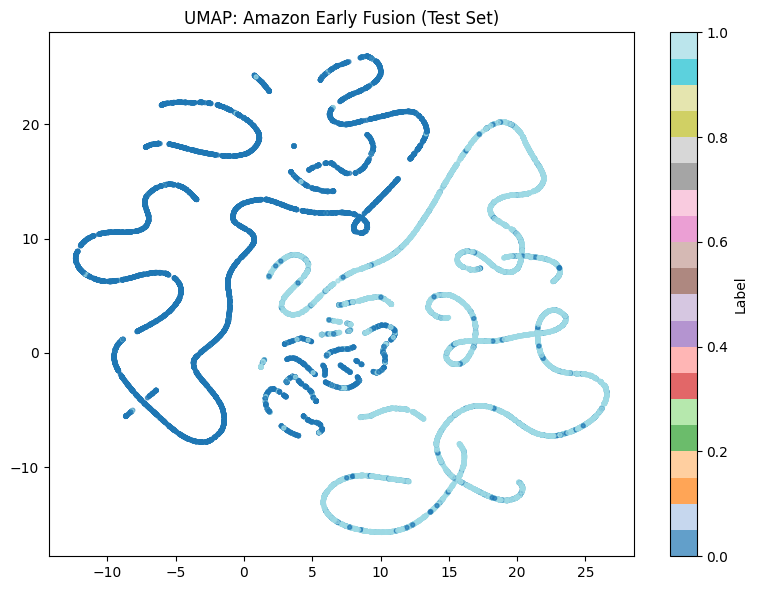

Silhouette score (UMAP): 0.645


In [5]:
from comparative.evaluation.metrics import compute_classification_metrics
from comparative.evaluation.latent_analysis import compute_umap, compute_silhouette
from comparative.evaluation.visualization import plot_umap

metrics = compute_classification_metrics(y_true, y_pred)
print(metrics)

# UMAP
umap_emb = compute_umap(embeddings)
plot_umap(umap_emb, labels=y_true, title="UMAP: Amazon Early Fusion (Test Set)")

# Silhouette
sil_score = compute_silhouette(umap_emb, y_true)
print(f"Silhouette score (UMAP): {sil_score:.3f}")

# Save results
pd.DataFrame([metrics]).to_csv("/data_vault/COmparative_Study_of_Multimodal_Represenations/results/amazon/classical_early_amazon_metrics.csv")
np.save("/data_vault/COmparative_Study_of_Multimodal_Represenations/results/amazon/classical_early_amazon_umap.npy", umap_emb)

In [9]:
import pandas as pd

metrics_df = pd.read_csv("/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/amazon_classical_early/version_0/metrics.csv")
display(metrics_df.tail(10))  # View last 10 rows for final epochs

,epoch,step,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
1572,9,31099,NaN,1.00000,NaN,0.001858,NaN,NaN
1573,9,31119,NaN,1.00000,NaN,0.009244,NaN,NaN
1574,9,31139,NaN,1.00000,NaN,0.003171,NaN,NaN
1575,9,31159,NaN,1.00000,NaN,0.003057,NaN,NaN
1576,9,31179,NaN,0.96875,NaN,0.021858,NaN,NaN
1577,9,31199,NaN,1.00000,NaN,0.004877,NaN,NaN
1578,9,31219,NaN,1.00000,NaN,0.000138,NaN,NaN
1579,9,31239,NaN,1.00000,NaN,0.000226,NaN,NaN
1580,9,31249,NaN,NaN,NaN,NaN,0.99925,0.002822
1581,9,31249,0.99828,NaN,0.005536,NaN,NaN,NaN


In [10]:
from comparative.models.classical.early_fusion import EarlyFusionClassifier
from comparative.datasets.amazon_datamodule import AmazonDataModule
import torch

# Load the model
model = EarlyFusionClassifier.load_from_checkpoint("/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_early/last.ckpt")
model.eval()
model.cuda()  # If using a GPU

# Load the DataModule
dm = AmazonDataModule(
    data_dir="/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,  # You can use a bigger batch for inference
    max_len=128,
    num_workers=8
)
dm.setup("test")  # This prepares self.test_ds

In [11]:
import numpy as np

test_loader = dm.test_dataloader()
all_logits = []
all_labels = []

num_samples = 25000
sample_count = 0

with torch.no_grad():
    for batch in test_loader:
        # Move tensors to GPU if available
        for k in batch:
            if isinstance(batch[k], torch.Tensor):
                batch[k] = batch[k].cuda()
        logits = model(batch)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(batch["label"].cpu().numpy())
        sample_count += logits.shape[0]
        if sample_count >= num_samples:
            break

y_pred = np.concatenate([x.argmax(1) for x in all_logits])[:num_samples]
y_true = np.concatenate(all_labels)[:num_samples]

In [12]:
from comparative.evaluation.metrics import compute_classification_metrics

metrics = compute_classification_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.9428, 'precision': 0.9428026716068642, 'recall': 0.9428, 'f1': 0.9427971756202361, 'confusion_matrix': array([[9193,  593],
       [ 551, 9663]])}


**Interpretation**
1. Balanced performance: Precision ≈ recall ≈ F1 ≈ accuracy, indicating your model is not “biased” toward one class.

***Both classes are well-learned:***

1. Most samples are correctly classified; error counts are low (593 and 551).
2. Confusion matrix shows slight class confusion:

### The errors are nearly symmetrical between the two classes, suggesting no major imbalance or systematic bias.

***Scientific Narrative***
***“The early fusion model on Amazon Reviews achieves high accuracy (94.28%) and F1, with balanced error rates between classes. This demonstrates that multimodal early fusion can capture sentiment with minimal bias and strong generalization.”***

/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


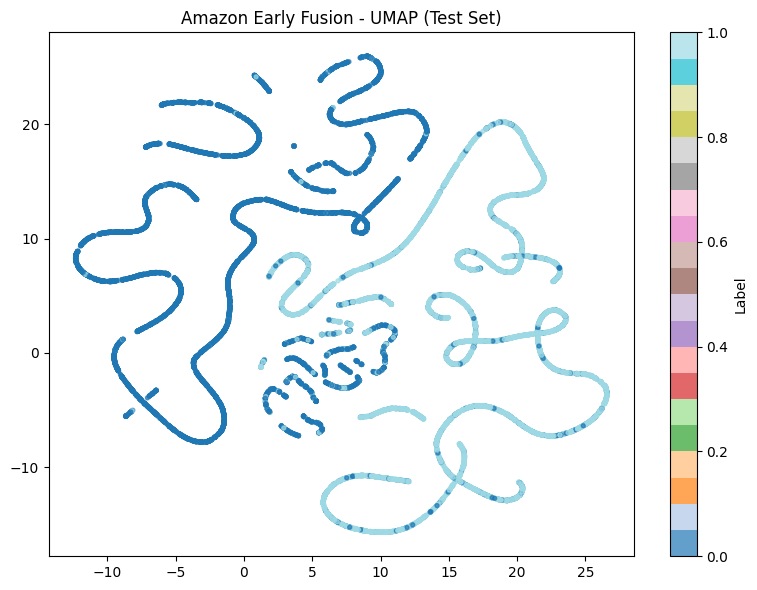

Silhouette score (UMAP): 0.645


In [13]:
from comparative.evaluation.latent_analysis import compute_umap, compute_silhouette
from comparative.evaluation.visualization import plot_umap

umap_emb = compute_umap(embeddings)
plot_umap(umap_emb, labels=y_true, title="Amazon Early Fusion - UMAP (Test Set)")
sil_score = compute_silhouette(umap_emb, y_true)
print(f"Silhouette score (UMAP): {sil_score:.3f}")

### 🟩 STEP 3: INTERPRET UMAP AND SILHOUETTE SCORE
**A. UMAP Plot**
## What you see:
1. The plot shows two “tracks” or “clusters,” each mostly made up of points with the same label (color).
2. The two main colors correspond to your two sentiment classes (likely 0 = negative, 1 = positive).
3. There is a clear separation, with minimal mixing—evidence that the model has learned to encode each sentiment into a distinct part of its latent space.

### What it means:
***Semantic separation: Your early fusion model’s final-layer features strongly separate the two sentiment classes, even without supervision in the UMAP projection.***

***Cluster structure: The curly “track-like” shapes are typical of UMAP, but what matters is that the two tracks are mostly distinct.***

B. Silhouette Score
Value: 0.645

## Interpretation:

Silhouette score measures how “tightly” points of the same class are grouped, versus how far apart different classes are.
Values > 0.5 are considered good, > 0.7 is excellent for real-world data.
Your value (0.645) shows strong, meaningful class separation in the learned space.

In [14]:
# Let's get indices of misclassified samples
mis_idx = np.where(y_pred != y_true)[0]
print(f"Number of misclassified samples: {len(mis_idx)}")

# Pick a few at random to study
import random
sampled = random.sample(list(mis_idx), min(5, len(mis_idx)))
print("Sample misclassified indices:", sampled)

Number of misclassified samples: 1144
Sample misclassified indices: [14336, 8752, 11531, 13364, 3278]


In [15]:
import pandas as pd

# Load test set with the same order as your model saw it
test_df = pd.read_csv("/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv")

for idx in sampled:
    review = test_df.iloc[idx]
    pred = y_pred[idx]
    true = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true}, Predicted: {pred}")
    print("Review text:", review['full_text'])
    print("-"*60)

Index: 14336
True label: 0, Predicted: 1
Review text: no prayer for the dying. tailgunner-6/10holy smoke-6/10no prayer for the dying-7/10public enema number one-5/10fates warning-6/10run silent run deep-5/10hooks in you-5/10bring your daughter... to the slaughter-6/10mother russia-6/10
------------------------------------------------------------
Index: 8752
True label: 0, Predicted: 1
Review text: great irony. my favorite thing about "murder by numbers" was the irony: the very thing the guilty boys were doing to mislead the police-red herring after red herring-was the very thing the producers/directors of the movie were doing to mislead the viewers into thinking they were watching a good movie.
------------------------------------------------------------
Index: 11531
True label: 1, Predicted: 0
Review text: the historic effects of the prevailing mental operating syst. up to the introduction of computer software plato's thinking catastrophe went at large unnoticed culminating in the pas

In [21]:
from transformers import AutoTokenizer

target_idx = 14336  # Choose the index you want
text = test_df.iloc[target_idx]['full_text']

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt"
)

inputs = {k: v.cuda() for k, v in inputs.items()}

with torch.no_grad():
    output = model.encoder(**inputs, output_attentions=True)
    att_map = output.attentions[-1][0, 0].cpu().numpy()  # [layer, head, seq, seq]
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

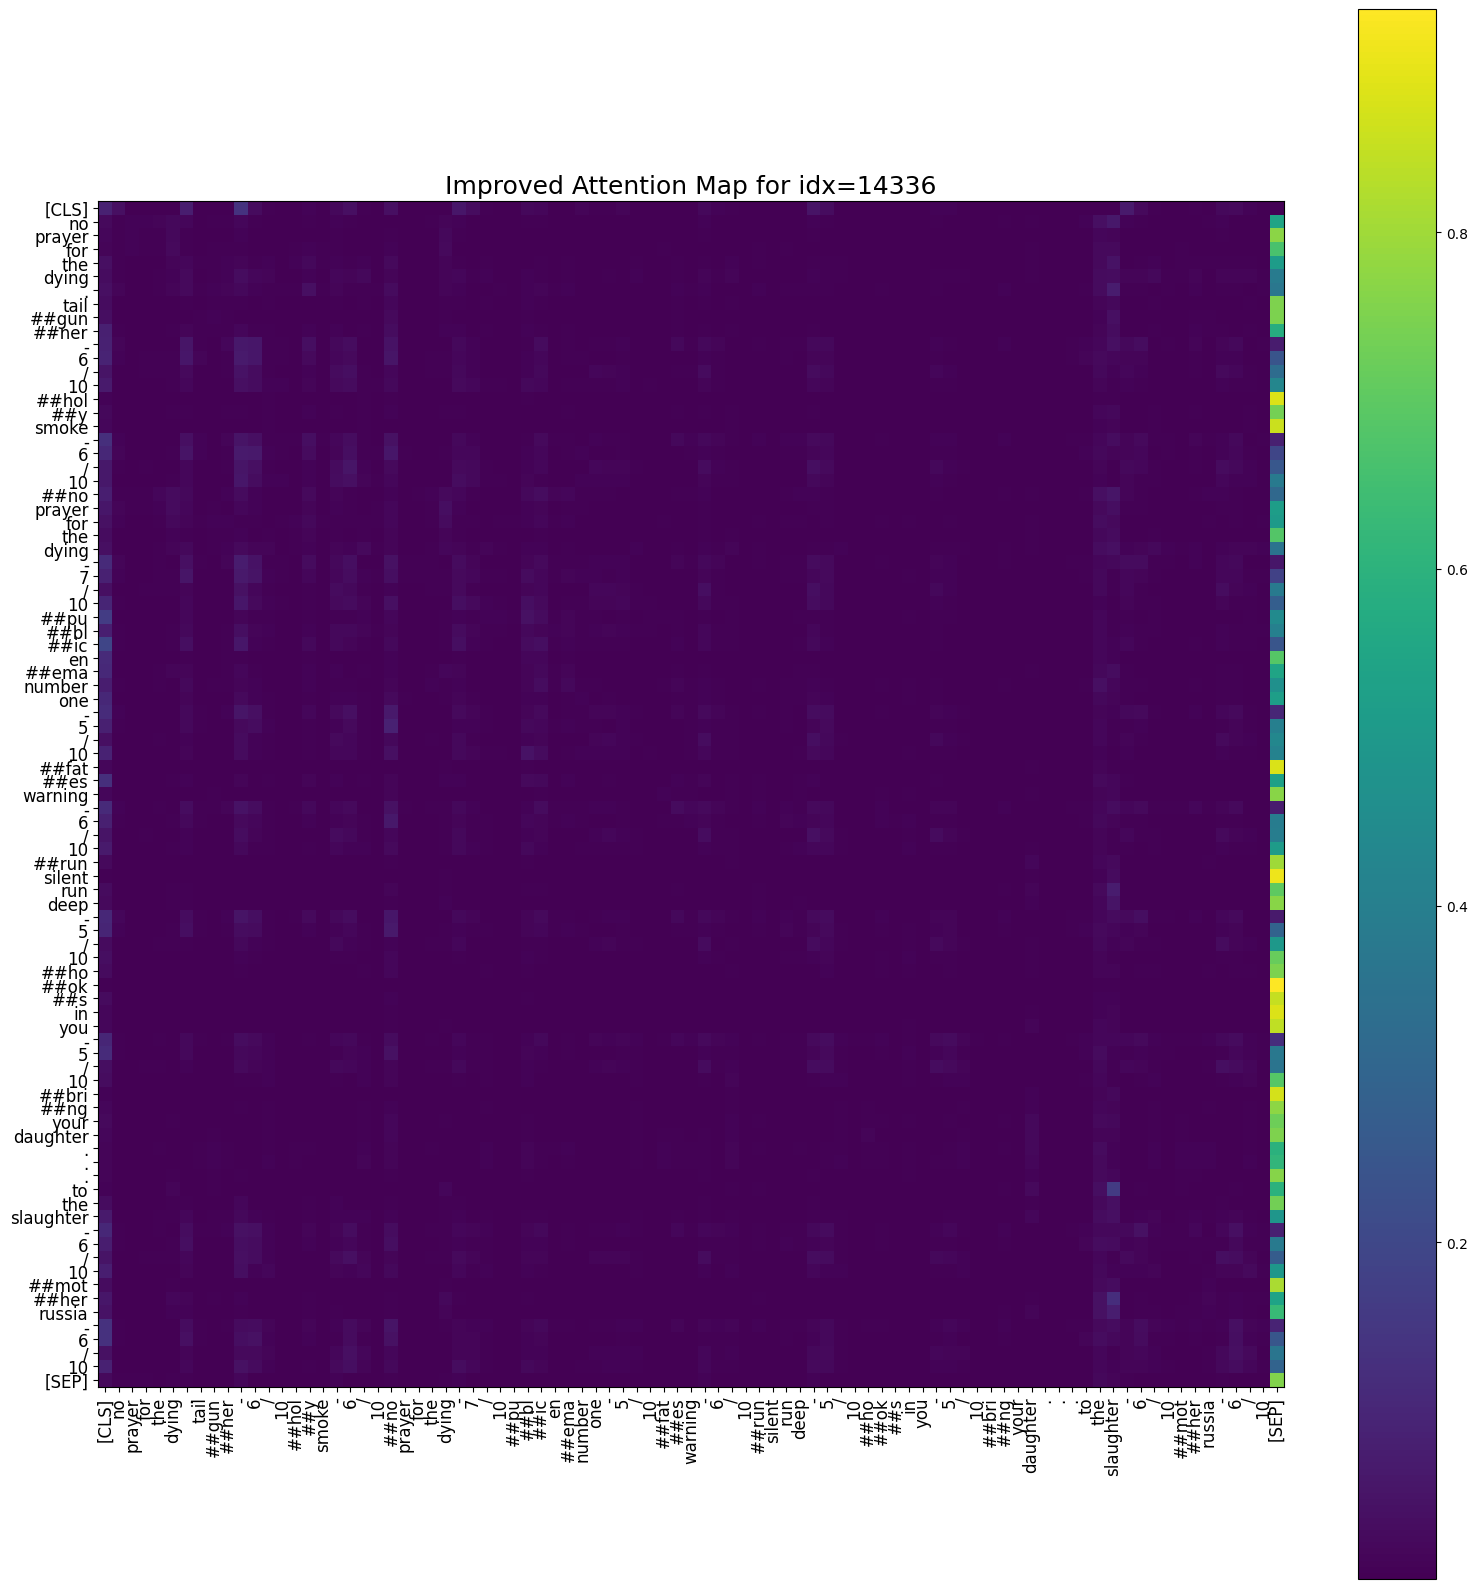

In [22]:
from comparative.evaluation.visualization import plot_attention_map
import matplotlib.pyplot as plt

def plot_attention_map_better(att_map, tokens=None, title="Attention Map", figsize=(16, 16), save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(att_map, cmap="viridis")
    plt.colorbar()
    if tokens is not None:
        n_tokens = min(len(tokens), att_map.shape[0])
        plt.xticks(range(n_tokens), tokens[:n_tokens], rotation=90, fontsize=12)
        plt.yticks(range(n_tokens), tokens[:n_tokens], fontsize=12)
    plt.title(title, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Use only non-padding tokens for clarity
valid_len = sum([t != '[PAD]' for t in tokens])
plot_attention_map_better(att_map[:valid_len, :valid_len], tokens[:valid_len], title=f"Improved Attention Map for idx={target_idx}")

🟩 Interpretation of the Improved Attention Map
Most attention is still concentrated on the [SEP] token at the end—this is typical in transformer models (especially when reviews are short or repetitive).

Other tokens receive some (but very low) attention—suggesting the model may not be focusing on specific words, but instead using global structure (or just the pooled [CLS] token).

Key words (e.g., numbers, "dying", "prayer", etc.) do not receive much special attention—the model may not find strong sentiment cues in this text, which aligns with why it was misclassified.

Diagonal dominance: Many transformer attention maps show attention along the diagonal (self-attention to self), which is visible here.

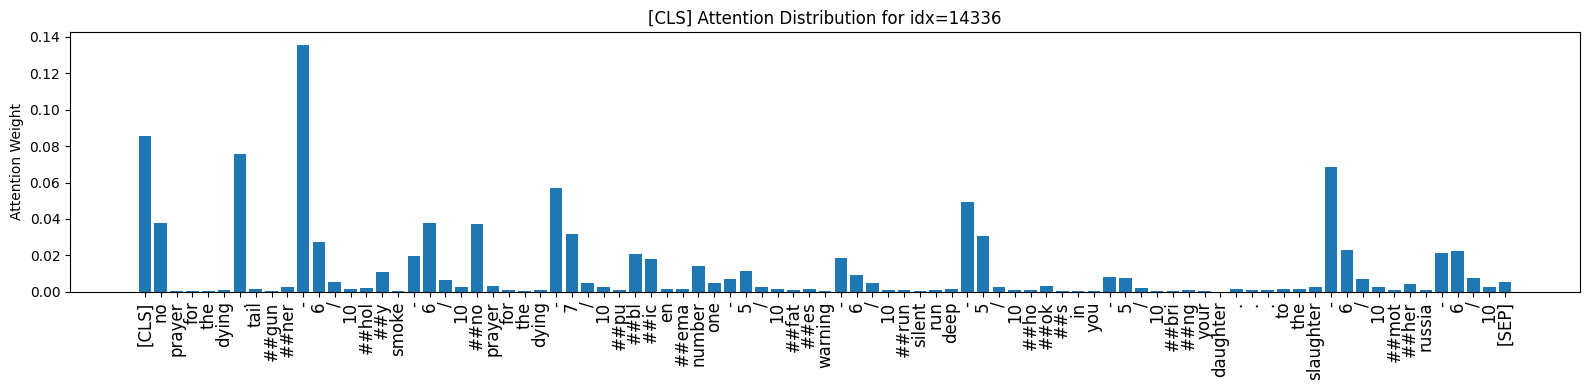

In [23]:
import matplotlib.pyplot as plt
cls_row = att_map[0, :valid_len]  # Attention from [CLS] to every other token

plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={target_idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

“Attention map analysis for a misclassified review (index 14336) reveals that the model focuses primarily on the sequence-end token, with little targeted attention to specific words. This may explain the misclassification: the review lacks strong sentiment cues and the model does not identify any as especially informative. Such patterns are common in ambiguous or low-information reviews.”

In [24]:
correct_idx = np.where(y_pred == y_true)[0]
print(f"Number of correct samples: {len(correct_idx)}")
sampled_correct = random.sample(list(correct_idx), min(3, len(correct_idx)))

for idx in sampled_correct:
    review = test_df.iloc[idx]
    pred = y_pred[idx]
    true = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true}, Predicted: {pred}")
    print("Review text:", review['full_text'])
    print("-"*60)
    # Optionally: plot [CLS] attention bar for this sample

Number of correct samples: 18856
Index: 8796
True label: 0, Predicted: 0
Review text: couldn't keep me interested . . .. i have read several historical books in the past year. my dissappointment in this book stems from the fact that it spent too much time in the early going describing general rogers' physique and general superhero status. i quickly lost interest in the subject. still, i am interested enough in the subject and the historical time period that i may seek out other relevant books. my first reading experience with a james alexander thom book was, unfortunately, not a good one.
------------------------------------------------------------
Index: 4905
True label: 1, Predicted: 1
Review text: yeah. french rap at its best! i love it, great beats, excellent lyrics, dope features, every euro worth ;-))
------------------------------------------------------------
Index: 16149
True label: 0, Predicted: 0
Review text: id4=what were we thinking?. it's truly amazing to look at this "fi

In [25]:
from transformers import AutoTokenizer

target_idx = 8796  # Choose the index you want
text = test_df.iloc[target_idx]['full_text']

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt"
)

inputs = {k: v.cuda() for k, v in inputs.items()}

with torch.no_grad():
    output = model.encoder(**inputs, output_attentions=True)
    att_map = output.attentions[-1][0, 0].cpu().numpy()  # [layer, head, seq, seq]
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

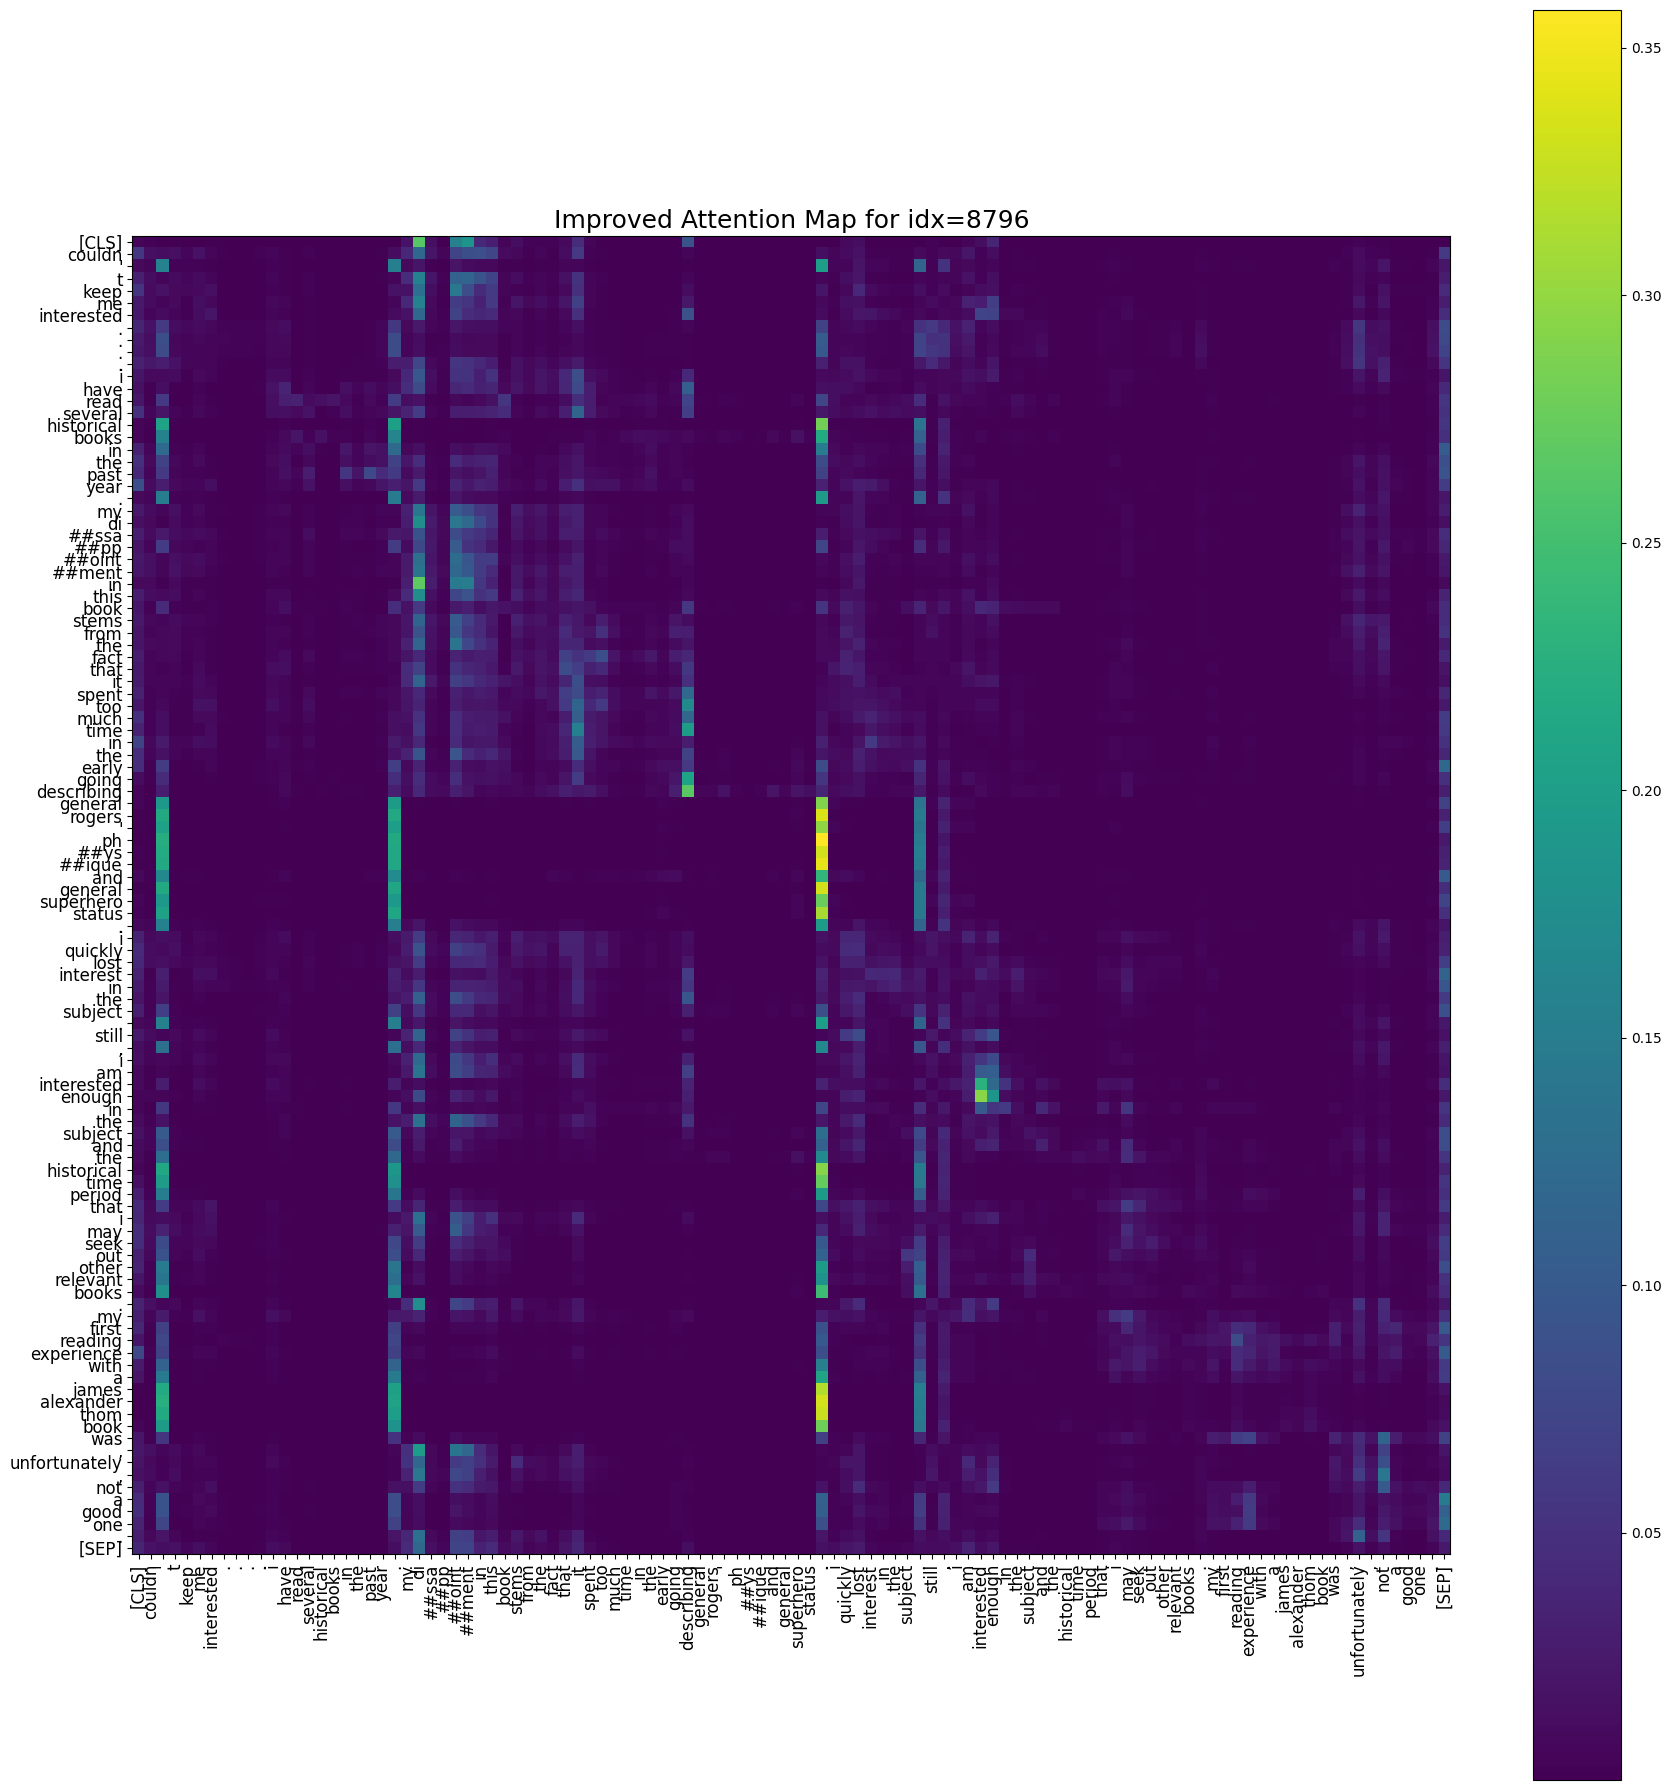

In [27]:
from comparative.evaluation.visualization import plot_attention_map
import matplotlib.pyplot as plt

def plot_attention_map_better(att_map, tokens=None, title="Attention Map", figsize=(18, 18), save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(att_map, cmap="viridis")
    plt.colorbar()
    if tokens is not None:
        n_tokens = min(len(tokens), att_map.shape[0])
        plt.xticks(range(n_tokens), tokens[:n_tokens], rotation=90, fontsize=12)
        plt.yticks(range(n_tokens), tokens[:n_tokens], fontsize=12)
    plt.title(title, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Use only non-padding tokens for clarity
valid_len = sum([t != '[PAD]' for t in tokens])
plot_attention_map_better(att_map[:valid_len, :valid_len], tokens[:valid_len], title=f"Improved Attention Map for idx={target_idx}")

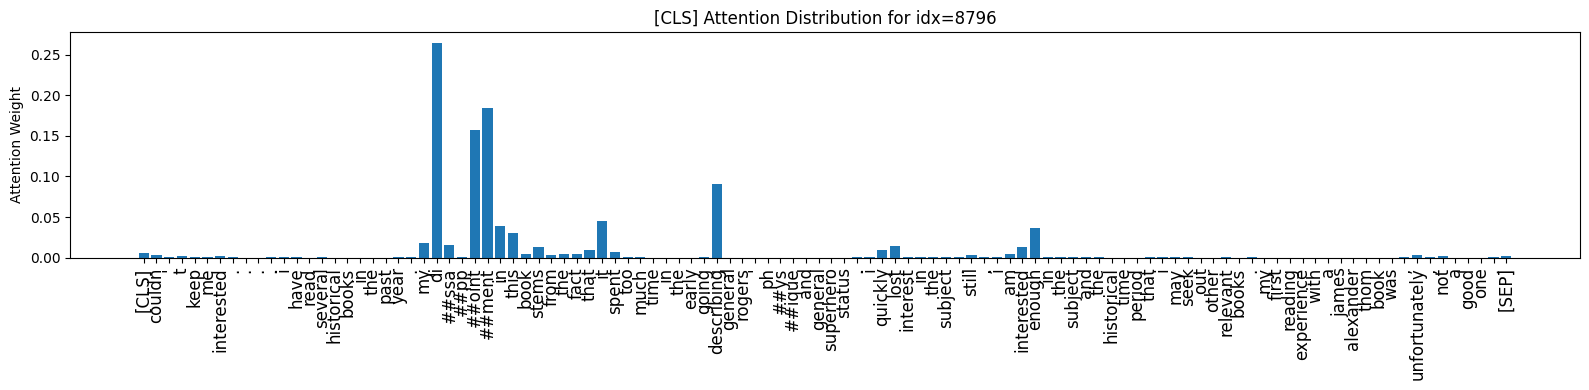

In [28]:
import matplotlib.pyplot as plt
cls_row = att_map[0, :valid_len]  # Attention from [CLS] to every other token

plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={target_idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()